In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np

## Import Dataset

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

class FingerprintDataset(Dataset):
    def __init__(self):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'./fingerprints/bace_fingerprints_classification.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
data = FingerprintDataset()

In [4]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [5]:
import best_config

#Get Model Parameters
hyperparameters = eval('best_config.'+best_config.GLOBALPARAMETERS['model_this_run']+'_HYPERPARAMETERS')

model_params = hyperparameters
model_params['feature_size'] = data.x.shape[1]

## Define Model

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
model_params

{'has_edge_info': False,
 'batch_size': 64,
 'learning_rate': 0.000986,
 'model_layers': 2,
 'model_embedding_size': 512,
 'model_dense_neurons': 64,
 'model_linear_dropout_rate': 0.0211,
 'model_embedding_dropout_rate': 0.149,
 'feature_size': 1016}

In [8]:
import models
print("Loading model...")

#Create instance of model
model = eval('models.'+best_config.GLOBALPARAMETERS['model_this_run']+'(model_params)')
print(model)
print(count_parameters(model))

Loading model...
MLP(
  (conv_layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
  )
  (initial_conv): Linear(in_features=1016, out_features=512, bias=True)
  (embedding_dropout): Dropout(p=0.149, inplace=False)
  (linear_dropout): Dropout(p=0.0211, inplace=False)
  (linear): Linear(in_features=512, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)
816257


In [9]:
model = model.to(device)

In [10]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  

train_size = 0.15
valid_size = train_size + 0.05

train = int(train_size * len(data))
valid = int(valid_size * len(data))
test = len(data) - train - valid
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(data, [train, valid, test])

NUM_FINGERPRINTS_PER_BATCH = model_params['batch_size']

# Wrap data in a data loader
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

NameError: name 'train_dataset' is not defined

## Training Loop

In [ ]:
def train(loader):
        model.train()
        # Enumerate over the data
        final_loss = 0
        for i, (fingerprint, labels) in enumerate(loader):  
            fingerprint = fingerprint.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(fingerprint)
            loss = loss_fn(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            final_loss += loss.item()
            loss.backward()
            optimizer.step() 
        return final_loss / len(loader)
    
def evaluate(loader):
        model.eval()
        # Enumerate over the data
        final_loss = 0
        for i, (fingerprint, labels) in enumerate(loader):  
            fingerprint = fingerprint.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(fingerprint)
            loss = loss_fn(outputs, labels)
            final_loss += loss.item()
        return final_loss / len(loader)

print("Starting training...")
losses = []
for epoch in range(100):
    loss = train(train_loader)
    val_loss = evaluate(valid_loader)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss} | Valid Loss {val_loss}")


Starting training...
Epoch 0 | Train Loss 0.6877337137858073 | Valid Loss 0.6882700794621518
Epoch 10 | Train Loss 0.1133084346850713 | Valid Loss 0.7576119256647009
Epoch 20 | Train Loss 0.05652410824938367 | Valid Loss 1.0738948865940696
Epoch 30 | Train Loss 0.01365986730476531 | Valid Loss 1.2045861259102821
Epoch 40 | Train Loss 0.044608585136806295 | Valid Loss 1.3294865089027506
Epoch 50 | Train Loss 0.020622998577164254 | Valid Loss 1.4015843711401288
Epoch 60 | Train Loss 0.04081671795089884 | Valid Loss 1.4400136721761603
Epoch 70 | Train Loss 0.02613449203709024 | Valid Loss 1.4964234013306468
Epoch 80 | Train Loss 0.03770664407434197 | Valid Loss 1.549140326286617
Epoch 90 | Train Loss 0.03760983501336644 | Valid Loss 1.5934702785391557


## Evaluate on the Test Set

In [ ]:
import pandas as pd 
model.eval()
true_values = []
predictions = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        output = model(fingerprint)
        true_values += labels.tolist()
        predictions += output.tolist()
df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
df = df.applymap(lambda x : x[0])
df

,y_pred,y_real
0,9.999945e-01,1.0
1,9.729298e-01,1.0
2,2.311161e-06,0.0
3,6.656446e-08,0.0
4,1.887598e-02,0.0
...,...,...
980,9.999532e-01,0.0
981,8.571637e-01,0.0
982,1.508232e-07,0.0
983,9.998047e-01,1.0


## Model Evaluation

In [ ]:
from sklearn import metrics

In [ ]:
output = df["y_pred"].apply(lambda x: int(round(x,0)))
output
binary_results = df.applymap(lambda x : int(round(x,0)))
binary_results

,y_pred,y_real
0,1,1
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
980,1,0
981,1,0
982,0,0
983,1,1


In [ ]:
report = metrics.classification_report(binary_results["y_real"],binary_results["y_pred"], output_dict=True)
report_string = metrics.classification_report(binary_results["y_real"],binary_results["y_pred"], output_dict=False)
report

accuracy = metrics.accuracy_score(binary_results["y_real"],binary_results["y_pred"])
f1 = metrics.f1_score(binary_results["y_real"],binary_results["y_pred"])
precision = metrics.precision_score(binary_results["y_real"],binary_results["y_pred"])
recall = metrics.recall_score(binary_results["y_real"],binary_results["y_pred"])
roc_auc = metrics.roc_auc_score(binary_results["y_real"],binary_results["y_pred"])
tn, fp, fn, tp = metrics.confusion_matrix(binary_results["y_real"],binary_results["y_pred"], labels=[0,1]).ravel()
specificity = tn / (tn+fp)
averageprecision = metrics.average_precision_score(df["y_real"].to_list(),df["y_pred"].to_list())

results = {
    'Accuracy':accuracy,
    'F1': f1,
    'Precision': precision,
    'Recall': recall,
    'ROCAUC': roc_auc,
    'Specificity': specificity,
    'Average Precision': averageprecision,
    'TN': tn,
    'FP': fp,
    'FN': fn,
    "TP": tp,
}

summary = pd.DataFrame([results])
filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
summary.to_csv(filepath + best_config.GLOBALPARAMETERS['model_this_run']+'summary.csv')
summary

,Accuracy,F1,Precision,Recall,ROCAUC,Specificity,Average Precision,TN,FP,FN,TP
0,0.758376,0.725173,0.721839,0.728538,0.755063,0.781588,0.793985,433,121,117,314


### Confusion Matrix

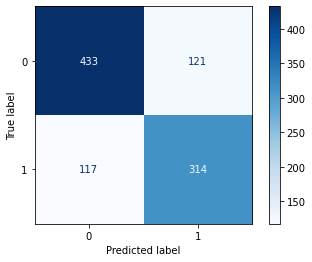

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
labels = [0,1]
cm = metrics.confusion_matrix(output,df["y_real"])
metrics.ConfusionMatrixDisplay.from_predictions(binary_results["y_real"],binary_results["y_pred"], cmap='Blues')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + best_config.GLOBALPARAMETERS['model_this_run'] + 'confusion_matrix.jpeg', bbox_inches='tight',dpi=100)

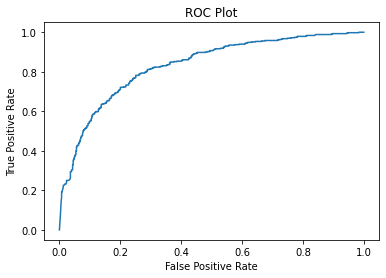

In [ ]:
r_fpr, r_tpr, thresholds = metrics.roc_curve(df["y_real"].to_list(),df["y_pred"].to_list())

roc_curve_data = pd.DataFrame({'r_fpr': r_fpr, 'r_tpr': r_tpr, 'thresholds': thresholds})

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
roc_curve_data.to_csv(filepath + best_config.GLOBALPARAMETERS['model_this_run']+'rocdata.csv')

import matplotlib.pyplot as plt

plt.plot(r_fpr, r_tpr)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + best_config.GLOBALPARAMETERS['model_this_run'] + 'roc_curve.jpeg', bbox_inches='tight', dpi=100)

Which metrics should you focus on?

- Choice of metric depends on your business objective
Spam filter (positive class is "spam"): Optimize for precision or specificity because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- Fraudulent transaction detector (positive class is "fraud"): Optimize for sensitivity because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

We can change the threshold for predicting a positive/negative class, which will changes the sensitivity and specificity of our model. How we should change this is informed by the ROC curve

### ROC Curve

Plotting the curve

In [ ]:

r_fpr, r_tpr, thresholds = metrics.roc_curve(df["y_real"].to_list(),df["y_pred"].to_list())

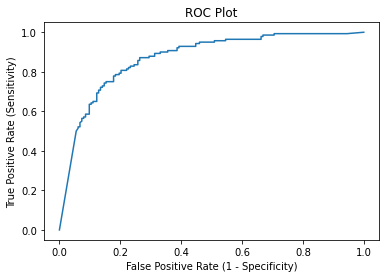

In [ ]:
import matplotlib.pyplot as plt

plt.plot(r_fpr, r_tpr)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
# Show plot
plt.show()

You can't directly see the threshold you want from the ROC curve, but you can evaluate the sensitivity and specificity as some specific threshold

In [ ]:
def evaluate_threshold(threshold):
    print('Sensitivity:', r_tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - r_fpr[thresholds > threshold][-1])

evaluate_threshold(0.3)

Sensitivity: 0.7857142857142857
Specificity: 0.8159509202453987


In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(df["y_real"].to_list(),df["y_pred"].to_list())

0.8274641600980353

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df["y_real"].to_list(),df["y_pred"].to_list())

In [ ]:
from sklearn.preprocessing import binarize
threshold = 0.3
predictions_with_new_threshold = binarize(df["y_pred"].to_numpy().reshape(-1,1), threshold = threshold)
predictions_with_new_threshold

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],